# Which Countries Dominate International Rugby?
### A data-driven look at win rates, point margins, defense, and World Cup success

This project analyzes more than a century of international rugby match results to understand which countries have consistently dominated the sport. Using win percentage, average point margin, defensive strength, and Rugby World Cup titles, the analysis evaluates both overall performance and seasonal trends. A combined Dominance Score is then used to rank nations and highlight how different strengths contribute to long-term success.


In [1]:
#cell 1: Imports + basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", None)


## Data Overview

This analysis uses a dataset containing historical international rugby match results from 1871 to the present. Each row represents a single match with details such as competing nations, match location, final scores, and tournament information. The dataset is transformed into a per-team format to allow calculation of win percentages, point margins, defensive performance, and season-by-season trends. Additional Rugby World Cup data is incorporated to capture performance in the sport’s most important competition.


In [2]:
#cell 2: Upload the rugby results CSV
from google.colab import files

print("Upload the international rugby results CSV you downloaded from Kaggle.")
uploaded = files.upload()

# Take the first uploaded file
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

df.head()


Upload the international rugby results CSV you downloaded from Kaggle.


Saving International Rugby Union results from 1871-2024.csv to International Rugby Union results from 1871-2024.csv


,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,world_cup
0,1871-03-27,Scotland,England,1,0,1871 Scotland v England International,Raeburn Place,Edinburgh,Scotland,False,False
1,1872-02-05,England,Scotland,2,1,1871–72 Home Nations International,The Oval,London,England,False,False
2,1873-03-03,Scotland,England,0,0,1872–73 Home Nations International,West of Scotland F.C.,Glasgow,Scotland,False,False
3,1874-02-23,England,Scotland,1,0,1873–74 Home Nations International,The Oval,London,England,False,False
4,1875-02-15,England,Ireland,2,0,1874–75 Home Nations rugby union matches,The Oval,London,England,False,False


In [3]:
#cell 3: Basic cleaning + add year
# Parse dates and add a 'year' column
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])
df["year"] = df["date"].dt.year

df.head()


,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,world_cup,year
0,1871-03-27,Scotland,England,1,0,1871 Scotland v England International,Raeburn Place,Edinburgh,Scotland,False,False,1871
1,1872-02-05,England,Scotland,2,1,1871–72 Home Nations International,The Oval,London,England,False,False,1872
2,1873-03-03,Scotland,England,0,0,1872–73 Home Nations International,West of Scotland F.C.,Glasgow,Scotland,False,False,1873
3,1874-02-23,England,Scotland,1,0,1873–74 Home Nations International,The Oval,London,England,False,False,1874
4,1875-02-15,England,Ireland,2,0,1874–75 Home Nations rugby union matches,The Oval,London,England,False,False,1875


In [4]:
#cell 4: Build a per-team per-match table
# Build "long" form: one row per team per match
home = df[["date", "year", "home_team", "away_team", "home_score", "away_score"]].copy()
home.rename(columns={
    "home_team": "team",
    "away_team": "opponent",
    "home_score": "points_for",
    "away_score": "points_against"
}, inplace=True)
home["is_home"] = True

away = df[["date", "year", "home_team", "away_team", "home_score", "away_score"]].copy()
away.rename(columns={
    "away_team": "team",
    "home_team": "opponent",
    "away_score": "points_for",
    "home_score": "points_against"
}, inplace=True)
away["is_home"] = False

team_matches = pd.concat([home, away], ignore_index=True)

# Win / draw / loss flags
team_matches["win"] = (team_matches["points_for"] > team_matches["points_against"]).astype(int)
team_matches["draw"] = (team_matches["points_for"] == team_matches["points_against"]).astype(int)
team_matches["loss"] = (team_matches["points_for"] < team_matches["points_against"]).astype(int)

team_matches.head()


,date,year,team,opponent,points_for,points_against,is_home,win,draw,loss
0,1871-03-27,1871,Scotland,England,1,0,True,1,0,0
1,1872-02-05,1872,England,Scotland,2,1,True,1,0,0
2,1873-03-03,1873,Scotland,England,0,0,True,0,1,0
3,1874-02-23,1874,England,Scotland,1,0,True,1,0,0
4,1875-02-15,1875,England,Ireland,2,0,True,1,0,0


## Average Point Margin Analysis

Average point margin per match reveals a team's ability not only to win, but to win convincingly. Teams with higher margins demonstrate strong offensive output and control over matches. The following visualization ranks nations by their average scoring margin.


In [5]:
#cell 5: Per-team overall stats
team_overall = (
    team_matches
    .groupby("team")
    .agg(
        matches=("team", "size"),
        wins=("win", "sum"),
        draws=("draw", "sum"),
        losses=("loss", "sum"),
        points_for=("points_for", "sum"),
        points_against=("points_against", "sum")
    )
)

team_overall["win_pct"] = team_overall["wins"] / team_overall["matches"] * 100
team_overall["margin_total"] = team_overall["points_for"] - team_overall["points_against"]

# 1) Average margin per match
team_overall["margin_per_match"] = team_overall["margin_total"] / team_overall["matches"]

# 2) Defense: average points allowed per match (lower is better)
team_overall["points_allowed_per_match"] = team_overall["points_against"] / team_overall["matches"]

# Filter out tiny rugby nations with very few games (adjust threshold if you like)
team_overall = team_overall[team_overall["matches"] >= 50].copy()

team_overall.sort_values("win_pct", ascending=False).head(10)


,matches,wins,draws,losses,points_for,points_against,win_pct,margin_total,margin_per_match,points_allowed_per_match
team,,,,,,,,,,
New Zealand,552,416,19,117,14498,7851,75.362319,6647,12.041667,14.222826
South Africa,446,271,18,157,10093,7719,60.762332,2374,5.322870,17.307175
England,741,391,52,298,11724,9928,52.766532,1796,2.423752,13.398111
France,686,344,31,311,11849,11327,50.145773,522,0.760933,16.511662
Australia,556,263,19,274,10968,10677,47.302158,291,0.523381,19.203237
Wales,693,322,29,342,10426,11083,46.464646,-657,-0.948052,15.992785
Ireland,682,295,30,357,9338,9929,43.255132,-591,-0.866569,14.558651
Scotland,669,259,32,378,8239,10404,38.714499,-2165,-3.236173,15.551570
Argentina,281,74,9,198,5068,7824,26.334520,-2756,-9.807829,27.843416


## Seasonal Margin Trends

Season-by-season average point margin provides insight into historical dominance. This helps identify golden eras, periods of decline, and long-term consistency. The chart below compares selected rugby powers across time, showing how their performance has evolved decade by decade.


In [6]:
#cell 6: Per-season (per-year) average margin
team_year = (
    team_matches
    .groupby(["team", "year"])
    .agg(
        matches_year=("team", "size"),
        wins_year=("win", "sum"),
        points_for_year=("points_for", "sum"),
        points_against_year=("points_against", "sum")
    )
    .reset_index()
)

# Margin per season (per year)
team_year["margin_per_match_year"] = (
    (team_year["points_for_year"] - team_year["points_against_year"]) /
    team_year["matches_year"]
)

# Keep only seasons with a minimum number of matches (e.g., 5) to avoid noise
min_matches_per_year = 5
filtered_year = team_year[team_year["matches_year"] >= min_matches_per_year].copy()

# 3) Average seasonal margin per team
avg_season_margin = (
    filtered_year
    .groupby("team")["margin_per_match_year"]
    .mean()
    .to_frame("avg_season_margin")
)

avg_season_margin.head()


,avg_season_margin
team,
Argentina,-9.219122
Australia,1.017307
England,2.428944
France,1.891192
Ireland,-1.133815


In [7]:
# cell 7: World Cup titles (winning seasons)
# Rugby World Cup winners (men's, 1987-2023)
world_cup_winners = {
    1987: "New Zealand",
    1991: "Australia",
    1995: "South Africa",
    1999: "Australia",
    2003: "England",
    2007: "South Africa",
    2011: "New Zealand",
    2015: "New Zealand",
    2019: "South Africa",
    2023: "South Africa",
}

# Count titles per team
wc_titles = {}
for year, winner in world_cup_winners.items():
    wc_titles[winner] = wc_titles.get(winner, 0) + 1

wc_titles_series = pd.Series(wc_titles, name="world_cup_titles")
wc_titles_series.index.name = "team"

wc_titles_series


,world_cup_titles
team,
New Zealand,3
Australia,2
South Africa,4
England,1


## Methodology & Metrics

The goal of this project is to compare international rugby nations using four primary indicators of dominance:

**1. Win Percentage**  
Measures how often a team wins across all international matches.

**2. Average Point Margin (Per Match)**  
Calculated as the difference between points scored and points conceded, divided by total matches. This reflects how convincingly a team wins.

**3. Defensive Strength (Least Points Allowed Per Match)**  
Lower average points conceded per game indicate a stronger defensive structure.

**4. Rugby World Cup Titles**  
World Cup championships reflect the ability to perform at the highest level under tournament pressure.

Additionally, **average seasonal point margin** is computed to reveal historical trends in dominance over time. All metrics are normalized and combined into a weighted Dominance Score that balances winning, scoring power, defensive performance, and championship success.


In [8]:
# cell 8: Combine all metrics into one DataFrame
# Merge per-season margin and World Cup titles into overall table
stats = team_overall.join(avg_season_margin, how="left")

stats = stats.join(wc_titles_series, how="left")
stats["world_cup_titles"] = stats["world_cup_titles"].fillna(0)

stats.head(10)


,matches,wins,draws,losses,points_for,points_against,win_pct,margin_total,margin_per_match,points_allowed_per_match,avg_season_margin,world_cup_titles
team,,,,,,,,,,,,
Argentina,281,74,9,198,5068,7824,26.334520,-2756,-9.807829,27.843416,-9.219122,0.0
Australia,556,263,19,274,10968,10677,47.302158,291,0.523381,19.203237,1.017307,2.0
England,741,391,52,298,11724,9928,52.766532,1796,2.423752,13.398111,2.428944,1.0
France,686,344,31,311,11849,11327,50.145773,522,0.760933,16.511662,1.891192,0.0
Ireland,682,295,30,357,9338,9929,43.255132,-591,-0.866569,14.558651,-1.133815,0.0
Italy,260,27,3,230,3653,9114,10.384615,-5461,-21.003846,35.053846,-21.456787,0.0
New Zealand,552,416,19,117,14498,7851,75.362319,6647,12.041667,14.222826,12.757908,3.0
Scotland,669,259,32,378,8239,10404,38.714499,-2165,-3.236173,15.551570,-4.581319,0.0
South Africa,446,271,18,157,10093,7719,60.762332,2374,5.322870,17.307175,4.713994,4.0


In [9]:
# cell 9: Build the Combined Dominance Score
stats_for_score = stats.copy()

# Helper to min–max normalize
def min_max_norm(series):
    s_min = series.min()
    s_max = series.max()
    if s_max == s_min:
        return pd.Series(0.5, index=series.index)  # fallback if constant
    return (series - s_min) / (s_max - s_min)

# Normalize metrics
stats_for_score["win_norm"] = min_max_norm(stats_for_score["win_pct"])
stats_for_score["margin_match_norm"] = min_max_norm(stats_for_score["margin_per_match"])
stats_for_score["season_margin_norm"] = min_max_norm(stats_for_score["avg_season_margin"].fillna(0))

# Defense: fewer points allowed per match is better → invert
defense_raw = stats_for_score["points_allowed_per_match"]
defense_norm_raw = min_max_norm(defense_raw)
stats_for_score["defense_norm"] = 1 - defense_norm_raw  # so lower points allowed => higher score

# World Cup titles: scale by max titles
max_titles = stats_for_score["world_cup_titles"].max()
if max_titles == 0:
    stats_for_score["wc_norm"] = 0
else:
    stats_for_score["wc_norm"] = stats_for_score["world_cup_titles"] / max_titles

# Weights for the dominance score (you can adjust later)
w_win = 0.40
w_margin_match = 0.25
w_margin_season = 0.15
w_defense = 0.10
w_wc = 0.10

stats_for_score["dominance_score"] = (
    w_win * stats_for_score["win_norm"] +
    w_margin_match * stats_for_score["margin_match_norm"] +
    w_margin_season * stats_for_score["season_margin_norm"] +
    w_defense * stats_for_score["defense_norm"] +
    w_wc * stats_for_score["wc_norm"]
)

# Sort by dominance score
dominant_teams = stats_for_score.sort_values("dominance_score", ascending=False)

dominant_teams.head(15)


,matches,wins,draws,losses,points_for,points_against,win_pct,margin_total,margin_per_match,points_allowed_per_match,avg_season_margin,world_cup_titles,win_norm,margin_match_norm,season_margin_norm,defense_norm,wc_norm,dominance_score
team,,,,,,,,,,,,,,,,,,
New Zealand,552,416,19,117,14498,7851,75.362319,6647,12.041667,14.222826,12.757908,3.0,1.000000,1.000000,1.000000,0.961917,0.75,0.971192
South Africa,446,271,18,157,10093,7719,60.762332,2374,5.322870,17.307175,4.713994,4.0,0.775308,0.796681,0.764899,0.819491,1.00,0.805977
England,741,391,52,298,11724,9928,52.766532,1796,2.423752,13.398111,2.428944,1.0,0.652253,0.708949,0.698113,1.000000,0.25,0.667856
Australia,556,263,19,274,10968,10677,47.302158,291,0.523381,19.203237,1.017307,2.0,0.568157,0.651442,0.656855,0.731936,0.50,0.611845
France,686,344,31,311,11849,11327,50.145773,522,0.760933,16.511662,1.891192,0.0,0.611920,0.658630,0.682396,0.856225,0.00,0.597408
Wales,693,322,29,342,10426,11083,46.464646,-657,-0.948052,15.992785,-2.563218,0.0,0.555268,0.606914,0.552206,0.880185,0.00,0.544685
Ireland,682,295,30,357,9338,9929,43.255132,-591,-0.866569,14.558651,-1.133815,0.0,0.505874,0.609380,0.593984,0.946410,0.00,0.538433
Scotland,669,259,32,378,8239,10404,38.714499,-2165,-3.236173,15.551570,-4.581319,0.0,0.435994,0.537673,0.493223,0.900559,0.00,0.472855
Argentina,281,74,9,198,5068,7824,26.334520,-2756,-9.807829,27.843416,-9.219122,0.0,0.245467,0.338806,0.357673,0.332957,0.00,0.269835


## Combined Dominance Score

To compare nations holistically, the analysis combines all major performance metrics into a single Dominance Score. This score incorporates win percentage, point margins, defensive strength, seasonal consistency, and World Cup titles. The resulting ranking identifies the most balanced and consistently successful teams in international rugby.


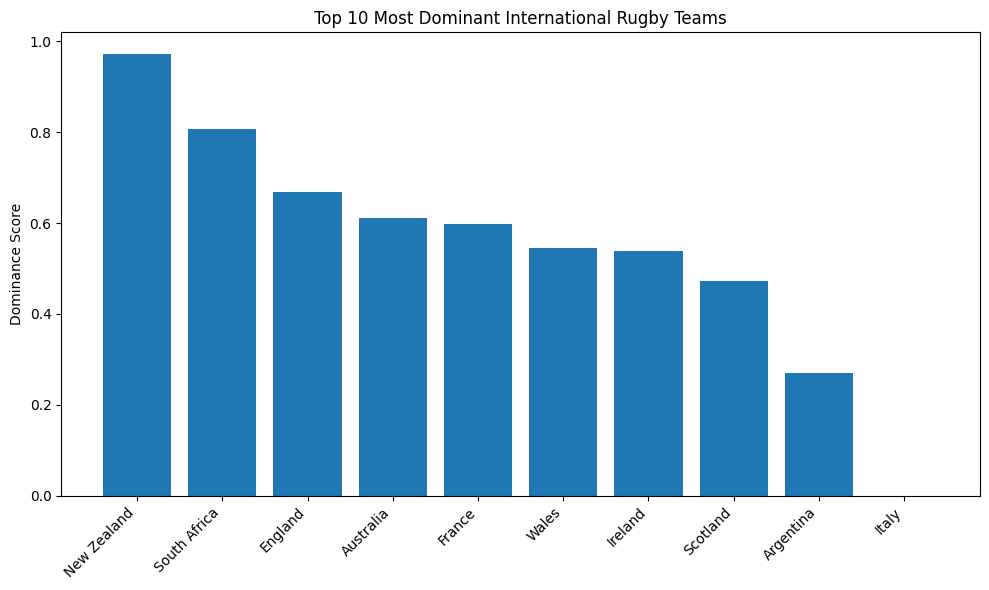

In [20]:
# cell 10
# 10.1 Top 10 by Dominance Score

top10 = dominant_teams.head(10)

plt.bar(top10.index, top10["dominance_score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Dominance Score")
plt.title("Top 10 Most Dominant International Rugby Teams")
plt.tight_layout()
plt.show()


## Win Percentage Analysis

Win percentage is the most straightforward measure of performance and provides an immediate sense of consistency. The following chart highlights the teams with the highest win rates across all recorded international matches. Auto-generated summaries below the chart highlight the top performers.


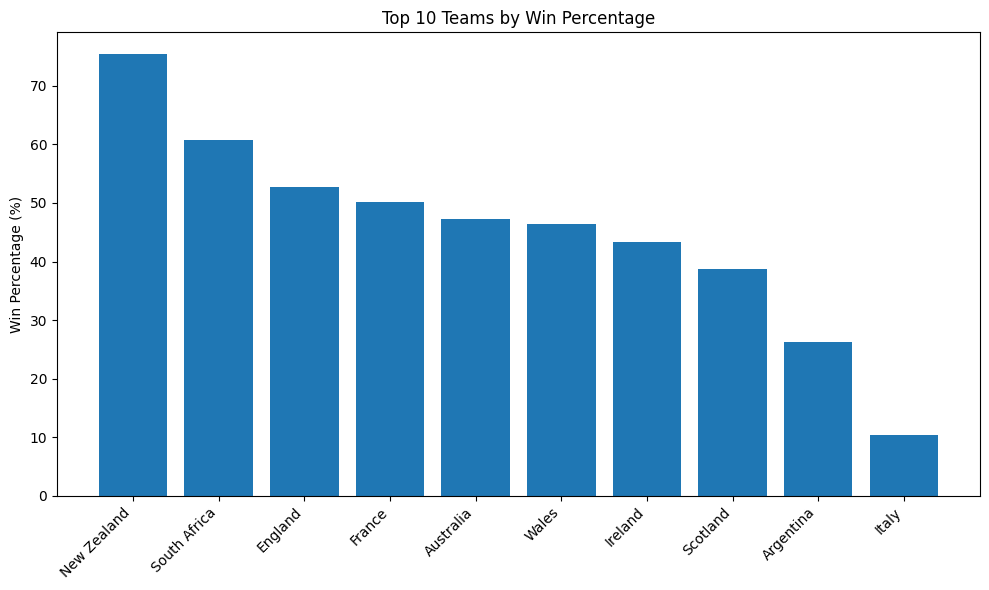

In [11]:
# cell 11
# 10.2: Top 10 by Win Percentage
top10_win = stats_for_score.sort_values("win_pct", ascending=False).head(10)

plt.bar(top10_win.index, top10_win["win_pct"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Win Percentage (%)")
plt.title("Top 10 Teams by Win Percentage")
plt.tight_layout()
plt.show()

## Defensive Performance

Defense is a defining feature of rugby success. Teams that consistently limit their opponents’ scoring typically maintain high match control and better tournament outcomes. This section ranks teams by their average points allowed per match, identifying the strongest defensive teams in international rugby.


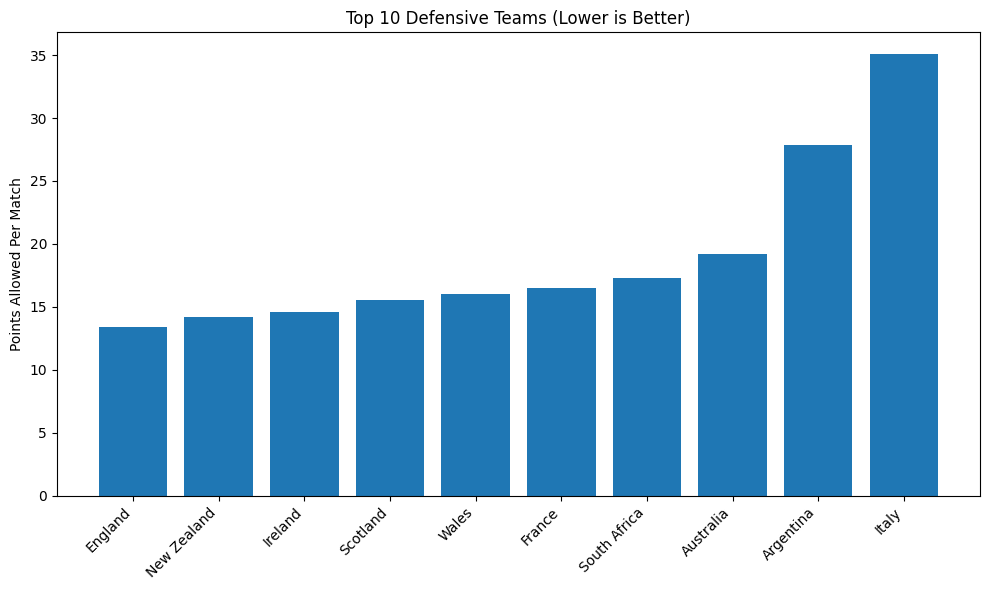

In [13]:
# cell 12
# 10.3: Best Defenses (fewest points allowed per match)
top10_def = stats_for_score.sort_values("points_allowed_per_match").head(10)

plt.bar(top10_def.index, top10_def["points_allowed_per_match"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Points Allowed Per Match")
plt.title("Top 10 Defensive Teams (Lower is Better)")
plt.tight_layout()
plt.show()


## Rugby World Cup Success

The Rugby World Cup is the ultimate test of international performance. By comparing the number of titles won by each nation, this section highlights which teams perform best on the sport’s biggest stage. World Cup victories are also incorporated into the Dominance Score as a measure of championship pedigree.


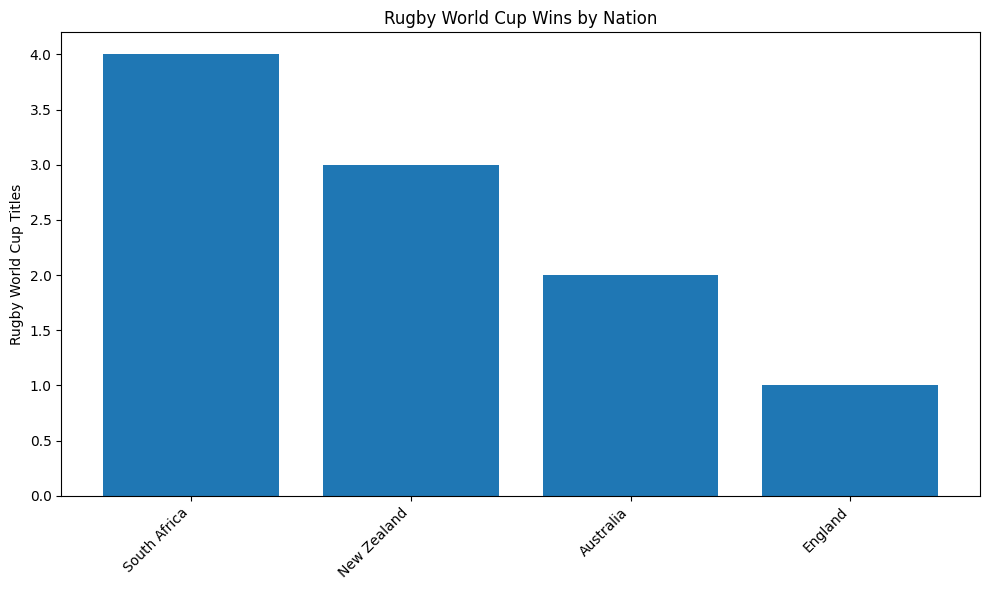

In [15]:
# cell 13
# 10.4 World Cup Titles
wc_sorted = stats_for_score[stats_for_score["world_cup_titles"] > 0].sort_values(
    "world_cup_titles", ascending=False
)

plt.bar(wc_sorted.index, wc_sorted["world_cup_titles"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Rugby World Cup Titles")
plt.title("Rugby World Cup Wins by Nation")
plt.tight_layout()
plt.show()


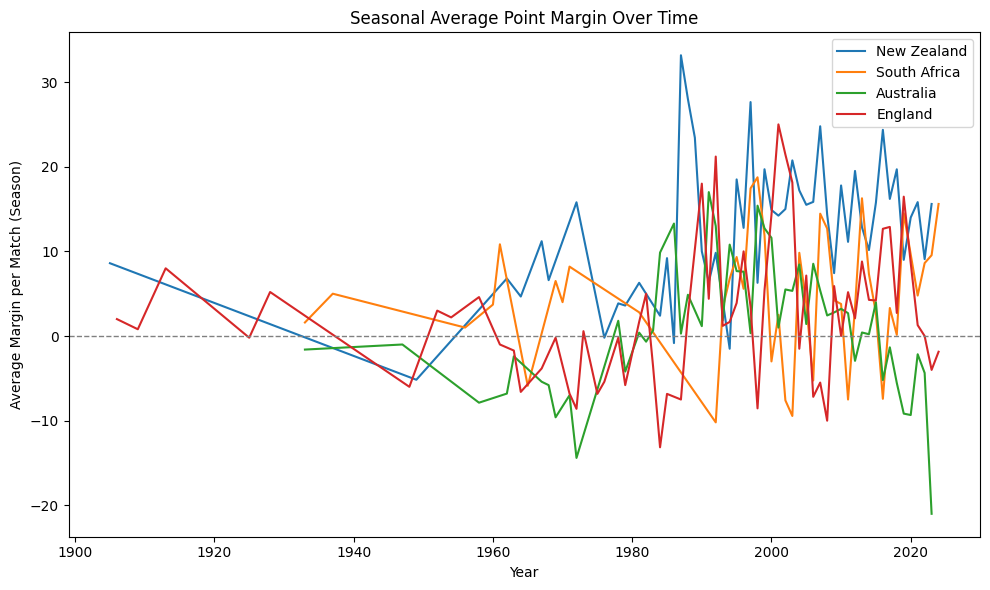

In [16]:
# cell 14
# 10.5 Historical dominance (per-season margin) for a few teams
teams_to_plot = ["New Zealand", "South Africa", "Australia", "England"]

plot_data = filtered_year[filtered_year["team"].isin(teams_to_plot)]

for team in teams_to_plot:
    team_data = plot_data[plot_data["team"] == team].sort_values("year")
    plt.plot(team_data["year"], team_data["margin_per_match_year"], label=team)

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Average Margin per Match (Season)")
plt.title("Seasonal Average Point Margin Over Time")
plt.legend()
plt.tight_layout()
plt.show()


## Auto-Generated Summaries

The following section includes automatically generated narrative summaries for each performance category. These summaries allows the notebook to describe the results directly from the data, ensuring accuracy without manual editing. This approach makes the project dynamic and ensures that insights remain aligned with the underlying dataset.


In [12]:
top_win = stats_for_score.sort_values("win_pct", ascending=False).head(3)
team1, team2, team3 = top_win.index

print(
    f"The teams with the highest win percentages are {team1}, {team2}, and {team3}. "
    f"{team1} leads all nations with a win rate of {top_win.iloc[0]['win_pct']:.1f}%."
)


The teams with the highest win percentages are New Zealand, South Africa, and England. New Zealand leads all nations with a win rate of 75.4%.


In [14]:
top_margin = stats_for_score.sort_values("margin_per_match", ascending=False).head(3)
m1, m2, m3 = top_margin.index

print(
    f"Based on average point margin per match, the most dominant attacking teams are "
    f"{m1}, {m2}, and {m3}. {m1} posts the highest margin at "
    f"{top_margin.iloc[0]['margin_per_match']:.2f} points per match."
)


Based on average point margin per match, the most dominant attacking teams are New Zealand, South Africa, and England. New Zealand posts the highest margin at 12.04 points per match.


In [17]:
top_season_margin = stats_for_score.sort_values("avg_season_margin", ascending=False).head(3)
s1, s2, s3 = top_season_margin.index

print(
    f"Across seasons, {s1}, {s2}, and {s3} show the strongest year-by-year dominance. "
    f"{s1} has the best average seasonal margin overall."
)


Across seasons, New Zealand, South Africa, and England show the strongest year-by-year dominance. New Zealand has the best average seasonal margin overall.


In [22]:
top_def = stats_for_score.sort_values("points_allowed_per_match").head(3)
d1, d2, d3 = top_def.index

print(
    f"The strongest defensive teams are {d1}, {d2}, and {d3}. "
    f"{d1} allows the fewest points per match on average."
)


The strongest defensive teams are England, New Zealand, and Ireland. England allows the fewest points per match on average.


In [23]:
wc_sorted = stats_for_score.sort_values("world_cup_titles", ascending=False)
wc_nonzero = wc_sorted[wc_sorted["world_cup_titles"] > 0].head(3)

wc1, wc2, wc3 = wc_nonzero.index

print(
    f"In terms of Rugby World Cup success, {wc1}, {wc2}, and {wc3} are the most accomplished teams. "
    f"{wc1} holds the most titles overall."
)


In terms of Rugby World Cup success, South Africa, New Zealand, and Australia are the most accomplished teams. South Africa holds the most titles overall.


In [24]:
top_dom = stats_for_score.sort_values("dominance_score", ascending=False).head(3)
dom1, dom2, dom3 = top_dom.index

print(
    f"According to the combined Dominance Score (win %, point margin, defense, and World Cup titles), "
    f"the top teams are {dom1}, {dom2}, and {dom3}. "
    f"{dom1} ranks #1 overall."
)


According to the combined Dominance Score (win %, point margin, defense, and World Cup titles), the top teams are New Zealand, South Africa, and England. New Zealand ranks #1 overall.


## Conclusion

This analysis provides a comprehensive view of international rugby dominance across multiple dimensions, including winning consistency, scoring power, defensive strength, and championship success. By combining these metrics into a single Dominance Score, the project highlights not only which teams have historically dominated, but also how their performance patterns differ. This approach offers a data-driven perspective on rugby’s competitive landscape and demonstrates how analytics can reveal deeper stories within the sport.
